In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PrepareData import prepare_dataset
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

## Prepare dataset

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset()

/home/simon/Dissertation/Abalone/PrepareData.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_test[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']])
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3383, 10) (3383,)
(376, 10) (376,)
(418, 10) (418,)


In [4]:
def plot_predictions(pred, y):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 30, 0.1), np.arange(0, 30, 0.1))

In [5]:
def sum_squared_error(pred, y):
    return np.sum((y - pred)**2)

## Encrypted Linear model

In [6]:
model_lin_weights = np.load('model_lin_weights.npy')

In [7]:
X_test_enc = EA(X_test.values, True)

In [8]:
w = EA(model_lin_weights[0])
b = EA(model_lin_weights[1].reshape(1, -1))

In [9]:
pred = X_test_enc.dot(w) + b
pred.shape

(418, 1)

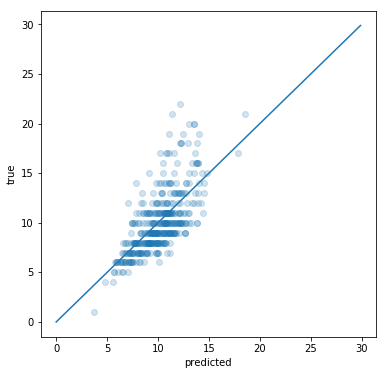

In [10]:
plot_predictions(pred.values().flatten(), y_test)

In [11]:
sse_enc = sum_squared_error(pred.values().flatten(), y_test)
print('SSE encrypted: {}'.format(sse_enc))

SSE encrypted: 2069.4778883855115


In [12]:
pred_clear = np.dot(X_test, model_lin_weights[0]) + model_lin_weights[1]
sse_clear = sum_squared_error(pred_clear.flatten(), y_test)
print('SSE clear: {}'.format(sse_clear))

SSE clear: 2069.4778883855115


## Linear - Batch Normalization

In [13]:
def normalize_weights(w, var, scale):
    return w * scale / np.sqrt(var + 0.001)

In [14]:
def normalize_bias(b, mean, var, shift, scale):
    return (b - mean) * (scale / np.sqrt(var + 0.001)) + shift

In [15]:
norm_weights = np.load('model_norm_weights.npy')

In [161]:
w1, b1, scale, shift, mean, std, w2, b2 = norm_weights

In [172]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale).reshape(1, -1)

In [19]:
w_norm_en = EA(w_norm)
b_norm_en = EA(b_norm)
w2_en = EA(w2)
b2_en = EA(b2.reshape(-1, 1))

In [20]:
layer1_enc = X_test_enc.dot(w_norm_en) + b_norm_en
pred_norm_enc = layer1_enc.dot(w2_en) + b2_en
pred_decrypted = pred_norm_enc.values()

In [21]:
sum_squared_error(pred_decrypted.reshape(-1,), y_test)

2606.9924618704367

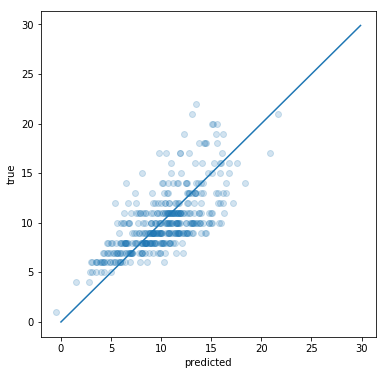

In [22]:
plot_predictions(pred_decrypted.reshape(-1,), y_test)

In [162]:
layer1 = X_test.values.dot(w_norm) + b_norm
pred_norm = layer1.dot(w2) + b2

In [182]:
l1 = X_train.values.dot(w_norm) + b_norm
# pred_ = l1.dot(w2) + b2
# pred_
l1.mean(axis=0)

array([ 1.56547561,  1.56616336, -1.78359515])

In [174]:
sum_squared_error(pred_.reshape(-1,), y_test)

2606.9924612842833

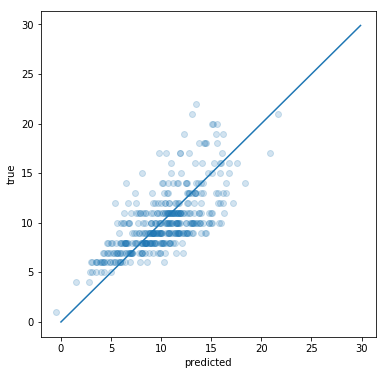

In [175]:
plot_predictions(pred_, y_test)

## Sigmoid model - 1 Layer

In [26]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [115]:
%autoreload 2

In [116]:
sig_weights = np.load('model_sig_weights.npy')

In [118]:
w1, scale, shift, mean, std, w2, b2 = sig_weights

In [119]:
w_norm = normalize_weights(w1, std**2, scale)

In [120]:
X_test_enc = EA(X_test.values, True)

In [121]:
w_norm_enc = EA(w_norm)
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [122]:
layer1 = X_test_enc.dot(w_norm_enc)

In [123]:
layer1.values()

array([[-0.24627554, -2.36715963,  3.31925869],
       [ 2.05571241, 10.99717707, -0.40627249],
       [ 4.35496195, -8.61358131,  3.01766016],
       ...,
       [-1.5638251 ,  2.91805418, -1.6678596 ],
       [-1.93837439,  3.9773344 , -2.31905571],
       [ 0.16718815,  9.11931745,  0.68925263]])

In [124]:
layer1_sig = layer1.activate_sigmoid()

In [125]:
layer1_sig.values()

array([[  0.43874225,   0.18450438,   0.56807033],
       [  0.8329707 , -24.45409625,   0.39982891],
       [ -0.13171073,  11.65851989,   0.68201421],
       ...,
       [  0.1887062 ,   0.71194335,   0.17967751],
       [  0.16711223,   0.1837474 ,   0.1800263 ],
       [  0.5416997 , -13.0172308 ,   0.66549253]])

In [126]:
pred_sig = layer1_sig.dot(w2_enc) + b2_enc

In [127]:
pred_sig.values()

array([[ 9.15229257e+00],
       [-9.18498158e+01],
       [ 5.52224667e+01],
       [-1.59105887e-01],
       [-2.57333682e+01],
       [ 3.14984226e+00],
       [ 9.94817865e+00],
       [ 6.77659113e+00],
       [ 1.03177485e+01],
       [-5.86334129e+01],
       [ 1.30365052e+01],
       [-6.13804728e+01],
       [ 9.95052661e+00],
       [-1.18718304e+01],
       [ 4.04262866e+00],
       [ 9.83836137e+00],
       [ 3.86427512e+00],
       [ 1.06388542e+01],
       [ 1.38042620e+00],
       [-2.51778099e+01],
       [-7.49268236e+01],
       [ 6.39222015e+00],
       [ 9.72841775e+00],
       [ 6.32332537e+00],
       [ 1.32231580e+02],
       [ 8.16715813e+00],
       [ 1.11386657e+02],
       [ 1.24002941e+01],
       [-4.36069284e+01],
       [ 4.43258803e+00],
       [ 8.94506271e+00],
       [ 4.15781809e+00],
       [-1.14887072e+01],
       [-6.20834199e+01],
       [ 1.27224302e+01],
       [ 1.38550980e+01],
       [ 1.27963964e+01],
       [ 9.18215564e+00],
       [-6.1

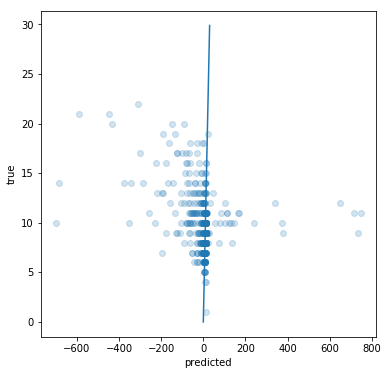

In [128]:
plot_predictions(pred_sig.values().reshape(-1,), y_test)

(-5, 50)

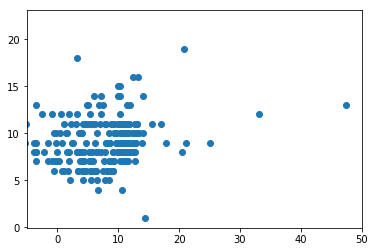

In [129]:
plt.scatter(pred_sig.values().reshape(-1,), y_test)
plt.xlim([-5, 50])

In [140]:
layer1_clear = X_test.values.dot(w_norm)
layer1_clear.mean(axis=0)

array([0.36154683, 4.03410186, 0.93955524])

In [141]:
layer1_sig_clear = sigmoid(layer1_clear)
pred_sig_clear = layer1_sig_clear.dot(w2) + b2

In [142]:
sse_sig_enc = sum_squared_error(pred_sig.values().flatten(), y_test)
print('SSE sigmoid enc: {}'.format(sse_sig_enc))

SSE sigmoid enc: 6229076.614660881


In [143]:
sse_sig_clear = sum_squared_error(pred_sig_clear.flatten(), y_test)
print('SSE sigmoid clear: {}'.format(sse_sig_clear))

SSE sigmoid clear: 4649.4428084223455


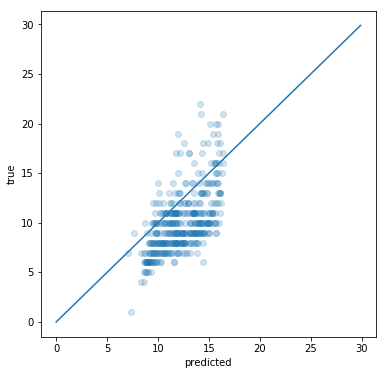

In [144]:
plot_predictions(pred_sig_clear.flatten(), y_test)

## Relu model - 1 Layer

In [279]:
def relu(z):
    return np.maximum(z, 0)

In [280]:
relu_weights = np.load('weights_relu.npy')

In [281]:
w1, b1, scale, shift, mean, std, w2, b2 = relu_weights

In [282]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale).reshape(1, -1)

In [283]:
layer1 = X_test_enc.dot(EA(w_norm)) + EA(b_norm.reshape(1, -1))
layer1.activate_squared()
pred_relu = layer1.dot(EA(w2)) + EA(b2.reshape(1, -1))

In [284]:
layer1_clear = X_test.values.dot(w_norm) + b_norm
layer1_relu_clear = relu(layer1_clear)
pred_relu_clear = layer1_relu_clear.dot(w2) + b2

In [285]:
sse_relu_enc = sum_squared_error(pred_relu.values().flatten(), y_test)
print('SSE relu enc: {}'.format(sse_relu_enc))

SSE relu enc: 5136334.508335641


In [286]:
sse_relu_clear = sum_squared_error(pred_relu_clear.flatten(), y_test)
print('SSE relu clear: {}'.format(sse_relu_clear))

SSE relu clear: 3885.6009372439958


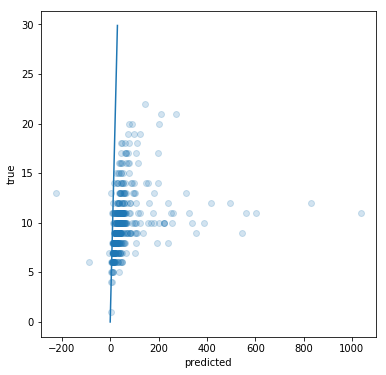

In [287]:
plot_predictions(pred_relu.values().flatten(), y_test)

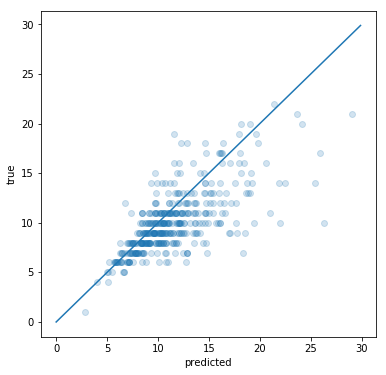

In [288]:
plot_predictions(pred_relu_clear.flatten(), y_test)